In [218]:
import numpy as np
import pandas
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt

In [366]:
# import data from csv
# col_list = [3, 9, 2, 12, 8, 7, 13]
# dataframe = pandas.read_csv('heart_full.csv',usecols = col_list, engine='python')
dataframe = pandas.read_csv('heart_full.csv',usecols = range(0,14), engine='python')
# dataframe = pandas.read_csv('heart.csv',usecols = range(0,14), engine='python')
# dataframe = pandas.read_csv('processed_cleveland.csv',usecols = range(0,14), engine='python')
dataset = dataframe.values

# seperate male
male_dataset = dataframe.loc[dataframe['sex'] == 1].values

# seperate female
female_dataset = dataframe.loc[dataframe['sex'] == 0].values

# dataset = female_dataset
dataset = np.delete(male_dataset, 1, axis=1)

print male_dataset.shape
print female_dataset.shape

(384, 14)
(183, 14)


In [367]:
# shuffle dataset
np.random.shuffle(dataset)

# find col length
num_cols = dataset.shape[1]

# divide data (X) and targets (Y)
X = np.delete(dataset, obj=num_cols-1, axis=1)
Y = dataset[:,num_cols-1]

# normalize data (X)
# X = sklearn.preprocessing.normalize(X, norm='l1', axis=0)


In [368]:
ENABLE_LOG_LOSS = True

# method to calculate accuracy
def calcAccuracy(actual, predicted):
#     print str(actual) + ", " + str(predicted)
#     return precision_score(actual, predicted)
#     return confusion_matrix(actual, predicted, labels=[2, 1])
    return accuracy_score(actual, predicted, normalize = True)


# method to test train/test split by percentage
def splitByPercentageValidation(param, train_size=0.7):
    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, train_size = train_size, random_state=2017)

    # normalize data
    scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)        

    # run on test and train data
    clf = buildClf(X_train, Y_train, param)
    
    predicted = clf.predict(X_test)    
    test_accuracy = calcAccuracy(Y_test, predicted)
    
    predicted = clf.predict(X_train)
    train_accuracy = calcAccuracy(Y_train, predicted)
    
    return train_accuracy, test_accuracy


# method for k-fold cross validation
def kFoldValidation(param, n_splits=10):
    kFold = KFold(n_splits=n_splits)

    # run on test data
    test_results = []
    train_results = []
    for train_index, test_index in kFold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # normalize data
        scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, param)
        
        predicted = clf.predict(X_test)
        test_accuracy = calcAccuracy(Y_test, predicted)
        
        predicted = clf.predict(X_train)
        train_accuracy = calcAccuracy(Y_train, predicted)
        
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
#     return train_accuracy, test_accuracy
    return np.mean(train_results, axis = 0), np.mean(test_results, axis = 0)


# method for leave one out cross validation
def looValidation(param):
    loo = sklearn.model_selection.LeaveOneOut()

    # run on test data
    test_results = []
    train_results = []
    Y_test_prob = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # normalize data
        scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # build classifier for each set
        clf = buildClf(X_train, Y_train, param)
        
        predicted = clf.predict(X_test)
        test_accuracy = calcAccuracy(Y_test, predicted)
        predicted = clf.predict(X_train)
        train_accuracy = calcAccuracy(Y_train, predicted)
        
        # save probability for log loss calculation
        if ENABLE_LOG_LOSS:
            Y_test_prob.append(clf.predict_proba(X_test)[0])
        
        test_results.append(test_accuracy)
        train_results.append(train_accuracy)
    
    # log loss calculation
    if ENABLE_LOG_LOSS:
        log_loss_value = log_loss(Y, Y_test_prob, labels=[1,2])
    else:
        log_loss_value = "NA"

#     return train_accuracy, test_accuracy
    return np.mean(train_results, axis = 0), np.mean(test_results, axis = 0), log_loss_value
#     return np.mean(train_results, axis = 0), np.sum(test_results, axis = 0), log_loss_value

    

In [375]:
# method to build classifier
def buildClf(train_data, train_target, param):
#     clf = DecisionTreeClassifier(max_depth = None, max_features = param, criterion = "entropy")# depth 13, feature 3
    clf = RandomForestClassifier(n_estimators = param)  # 42
#     clf = KNeighborsClassifier(param)  # 9
#     clf = AdaBoostClassifier(n_estimators = param)  # 9
#     clf = GradientBoostingClassifier(n_estimators = param)  # 5
#     clf = GaussianNB()
#     clf = MultinomialNB()
#     clf = BernoulliNB()
#     clf = GaussianProcessClassifier(n_jobs = -1)
#     clf = LinearDiscriminantAnalysis()
#     clf = QuadraticDiscriminantAnalysis()
#     clf = SVC(kernel="linear") 
#     clf = BaggingClassifier(GaussianNB(), max_samples=0.7, max_features=0.8)
#     clf = BaggingClassifier(QuadraticDiscriminantAnalysis(), max_samples=0.2, max_features=0.3)
#     clf = BaggingClassifier(DecisionTreeClassifier(max_features = 2, criterion = "entropy"), max_samples=0.5, max_features=6)
#     clf = LogisticRegression()
#     clf = MLPClassifier(solver = 'lbfgs')

#     clf_1 = MLPClassifier(solver = 'lbfgs')
    clf_1 = GaussianNB()
#     clf_1 = BaggingClassifier(GaussianNB(), max_samples=0.7, max_features=0.8)
#     clf_2 = AdaBoostClassifier(n_estimators = param) # 6
    clf_2 = DecisionTreeClassifier(max_features = 2, criterion = "entropy")
    clf_3 = BernoulliNB()
#     clf_3 = RandomForestClassifier(n_estimators = 42)
#     clf = VotingClassifier(estimators=[('mlp', clf_1), ('dt', clf_2), ('rf', clf_3)], voting='soft', weights = [1,1,1], n_jobs = -1)
#     clf = VotingClassifier(estimators=[('mlp', clf_1), ('dt', clf_2), ('rf', clf_3)], voting='hard')
    
    clf.fit(train_data, train_target)
    return clf

In [ ]:
# for creating csv file of results
param = 42
loo_train, loo_test, log_loss_value = looValidation(param)

print "Classifier, Train Accuracy, Test Accuracy, Log Loss"
print "Classifier, " + str(loo_train) + ", " + str(loo_test) + ", " + str(log_loss_value)


In [372]:
# results array format: [[train], [test]]
splitByPercentageResults = [[],[]]
kFoldResults = [[],[]]
looResults = [[],[],[]]

# run iterations
x = range(40, 61)
for param in x:
    print param
#     splitByPercentage_train, splitByPercentage_test = splitByPercentageValidation(param, 0.85)
#     kFold_train, kFold_test = kFoldValidation(param, 5)
    loo_train, loo_test, log_loss_value = looValidation(param)
    
#     splitByPercentageResults[0].append(1-splitByPercentage_train)
#     splitByPercentageResults[1].append(1-splitByPercentage_test)
    
#     kFoldResults[0].append(1-kFold_train)
#     kFoldResults[1].append(1-kFold_test)
    
    looResults[0].append(1-loo_train)
    looResults[1].append(1-loo_test)
    looResults[2].append(log_loss_value)
    
print "Done"


40


KeyboardInterrupt: 

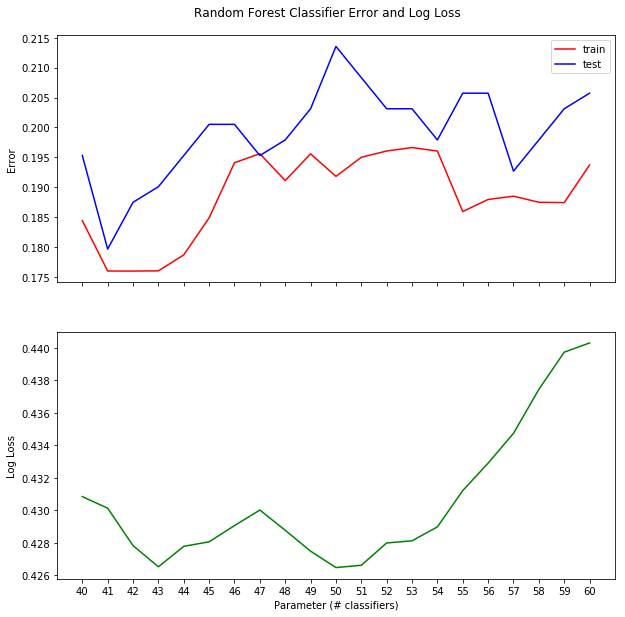

In [363]:
# # plot accuracy graph
# plt.figure(1, figsize = (15, 15))
# plt.subplot(211)
# plt.xlabel('Parameter (max features)')
# plt.ylabel('Error')
# plt.title('Decision Tree Classifier Error and Log Loss')
# plt.plot(x, looResults[0], color='r', label='train')
# plt.plot(x, looResults[1], color='b', label='test')
# plt.xticks(x)
# plt.legend()

# # plot log loss graph
# plt.subplot(212)
# plt.xlabel('Parameter (max features)')
# plt.ylabel('Log Loss')
# plt.plot(x, looResults[2], color='g', label='log loss')
# plt.xticks(x)
# plt.show()

f, axarr = plt.subplots(2, sharex=True)
f.suptitle('Random Forest Classifier Error and Log Loss', y = 0.92)
f.set_size_inches(10, 10)
axarr[0].set_ylabel('Error')
axarr[0].plot(x, looResults[0], color='r', label='train')
axarr[0].plot(x, looResults[1], color='b', label='test')
axarr[0].legend()
axarr[1].set_ylabel('Log Loss')
axarr[1].plot(x, looResults[2], color='g', label='log loss')
axarr[1].set_xticks(x)
axarr[1].set_xlabel('Parameter (# classifiers)')
plt.show()

In [359]:
param = 42

splitByPercentage_train, splitByPercentage_test = splitByPercentageValidation(param, 0.85)
kFold_train, kFold_test = kFoldValidation(param, 5)
loo_train, loo_test, log_loss_value = looValidation(param)

print "-----Train-----"
print "Split by % Accuracy: {}".format(splitByPercentage_train)
print "K-Fold Accuracy: {}".format(kFold_train)
print "Leave-One-Out Accuracy: {}".format(loo_train)

print "-----Test-----"
print "Split by % Accuracy: {}".format(splitByPercentage_test)
print "K-Fold Accuracy: {}".format(kFold_test)
print "Leave-One-Out Accuracy: {}".format(loo_test)
print "Log Loss for LOO: {}".format(log_loss_value)

-----Train-----
Split by % Accuracy: 0.814968814969
K-Fold Accuracy: 0.817464577802
Leave-One-Out Accuracy: 0.811293709998
-----Test-----
Split by % Accuracy: 0.848837209302
K-Fold Accuracy: 0.811224965068
Leave-One-Out Accuracy: 0.809523809524
Log Loss for LOO: 0.555965194859


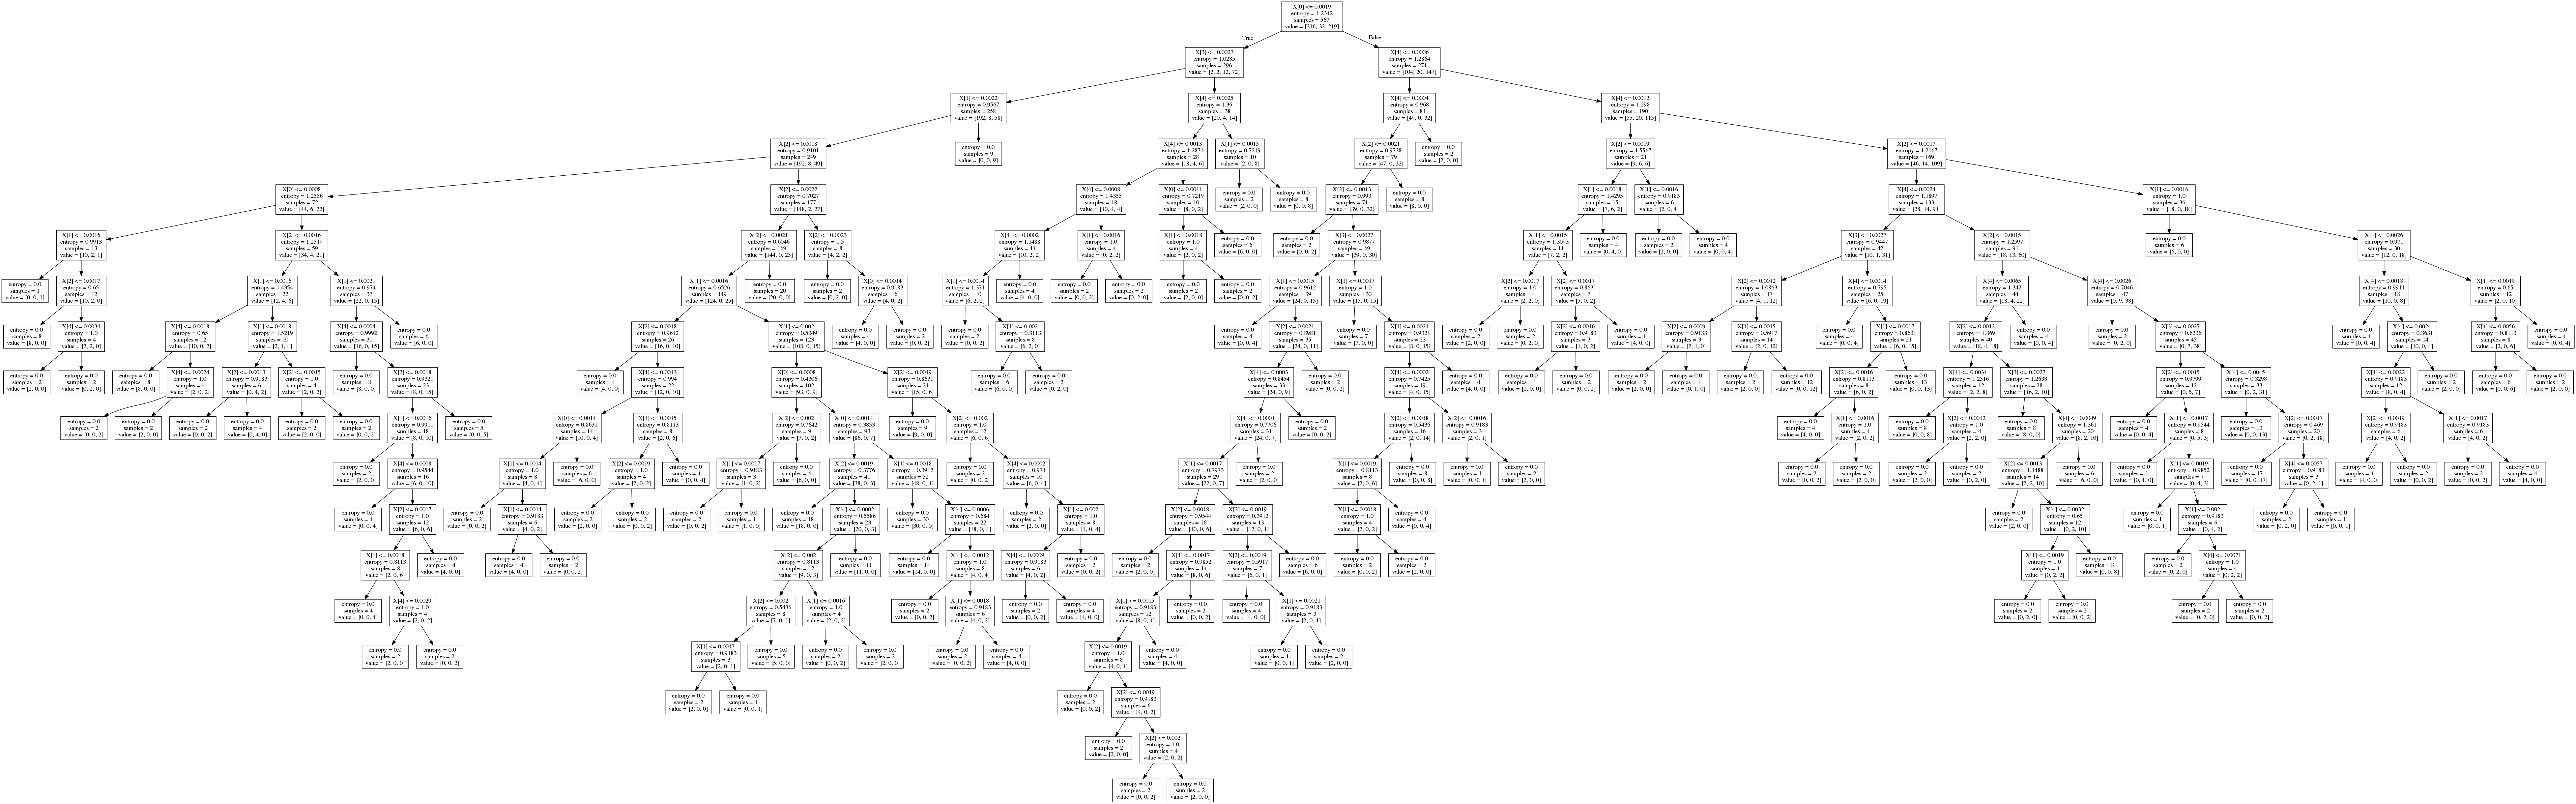

In [240]:
# visualize the decision tree
# from: http://scikit-learn.org/stable/modules/tree.html

clf = buildClf(X, Y, 2)

import pydotplus 
from IPython.display import Image  
dot_data = sklearn.tree.export_graphviz(clf, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())
# graph.write_pdf("decision-tree.pdf") 

In [216]:
dataframe.columns[11]

'major vessels'